In [13]:
import intake
from easygems import healpix as egh
import easygems.remap as egr
import healpy as hp

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning) # don't warn us about future package conflicts

In [3]:
current_location = "NCAR" #"online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]
list(cat)

['ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'mpas_dyamond1',
 'mpas_dyamond2',
 'mpas_dyamond3',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

In [4]:
import pandas as pd

pd.DataFrame(cat["mpas_dyamond1"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,temporal resolution of the dataset,str,"[PT15M, PT3H]",PT3H
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]",7


In [12]:
scream = cat['scream2D_hrly'](zoom = 7).to_dask()
scream

<xarray.Dataset> Size: 15GB
Dimensions:   (crs: 0, time: 9457, cell: 196608)
Coordinates:
  * crs       (crs) float64 0B 
  * time      (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    pr        (time, cell) float32 7GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    rlut      (time, cell) float32 7GB dask.array<chunksize=(24, 196608), meta=np.ndarray>
    ELEV      (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    LANDFRAC  (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    lat       (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
    lon       (cell) float32 786kB dask.array<chunksize=(4096,), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

In [16]:
scream_precip = scream.pr
scream_precip
scream_precip_mmhr = scream_precip * 36e5

In [17]:
import cftime 
start_time = cftime.DatetimeNoLeap(2020, 6, 1, 0, 0, 0, 0)
end_time = cftime.DatetimeNoLeap(2020, 6, 30, 0, 0, 0, 0)
scream_precip_june =  scream_precip_mmhr.sel(time=slice(start_time, end_time)).mean(dim="time").compute()

In [27]:
def get_NCL_colormap(cmap_name, extend='None'):
    '''Read an NCL RGB colormap file and convert it to a Matplotlib colormap
    object.

    Parameter:
        cmap_name     NCL RGB colormap name, e.g. 'ncl_default'
        extend        use NCL behavior of color handling for the colorbar 'under'
                      and 'over' colors. 'None' or 'ncl', default 'None'

    Description:
        Read the NCL colormap and convert it to a Matplotlib Colormap object.
        It checks if the colormap file is already available or use the
        appropriate URL.

        If NCL is installed the colormap will be searched in its colormaps
        folder $NCARG_ROOT/lib/ncarg/colormaps.

        Returns a Matplotlib Colormap object.
    '''
    from matplotlib.colors import ListedColormap
    import requests
    import errno
    import os, re
    import numpy as np

    #-- NCL colormaps URL
    NCARG_URL = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/'

    #-- read the NCL colormap RGB file
    colormap_file = cmap_name+'.rgb'
    cfile = os.path.split(colormap_file)[1]

    if os.path.isfile(colormap_file) == False:
        #-- if NCL is already installed
        if 'NCARG_ROOT' in os.environ:
            cpath = os.environ['NCARG_ROOT']+'/lib/ncarg/colormaps/'
            if os.path.isfile(cpath + cfile):
                colormap_file = cpath + cfile
                with open(colormap_file) as f:
                    lines = [re.sub('\s+',' ',l)  for l in f.read().splitlines() if not (l.startswith('#') or l.startswith('n'))]
        #-- use URL to read colormap
        elif not 'NCARG_ROOT' in os.environ:
            url_file = NCARG_URL+'/'+cmap_name+'.rgb'
            res = requests.head(url_file)
            if not res.status_code == 200:
                print(f'{cmap_name} does not exist!')
                raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), cmap_name)
            content = requests.get(url_file, stream=True).content
            lines = [re.sub('\s+',' ',l)  for l in content.decode('UTF-8').splitlines() if not (l.startswith('#') or l.startswith('n'))]
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), colormap_file)
    #-- use local colormap file
    else:
        with open(colormap_file) as f:
            lines = [re.sub('\s+',' ',l)  for l in f.read().splitlines() if not (l.startswith('#') or l.startswith('n'))]

    #-- skip all possible header lines
    tmp  = [l.split('#', 1)[0] for l in lines]

    tmp = [re.sub(r'\s+',' ', s) for s in tmp]
    tmp = [ x for x in tmp if ';' not in x ]
    tmp = [ x for x in tmp if x != '']

    #-- get the RGB values
    i = 0
    for l in tmp:
        new_array = np.array(l.split()).astype(float)
        if i == 0:
            color_list = new_array
        else:
            color_list = np.vstack((color_list, new_array))
        i += 1

    #-- make sure that the RGB values are within range 0 to 1
    if (color_list > 1.).any(): color_list = color_list / 255

    #-- add alpha-channel RGB -> RGBA
    alpha        = np.ones((color_list.shape[0],4))
    alpha[:,:-1] = color_list
    color_list   = alpha

    #-- convert to Colormap object
    if extend == 'ncl':
        cmap = ListedColormap(color_list[1:-1,:])
    else:
        cmap = ListedColormap(color_list)

    #-- define the under, over, and bad colors
    under = color_list[0,:]
    over  = color_list[-1,:]
    bad   = [0.5, 0.5, 0.5, 1.]
    cmap.set_extremes(under=color_list[0], bad=bad, over=color_list[-1])

    return cmap

<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\s'
/glade/derecho/scratch/weiyiwang/tmp/ipykernel_91841/248976764.py:40: SyntaxWarning: invalid escape sequence '\s'
  lines = [re.sub('\s+',' ',l)  for l in f.read().splitlines() if not (l.startswith('#') or l.startswith('n'))]
/glade/derecho/scratch/weiyiwang/tmp/ipykernel_91841/248976764.py:49: SyntaxWarning: invalid escape sequence '\s'
  lines = [re.sub('\s+',' ',l)  for l in content.decode('UTF-8').splitlines() if not (l.startswith('#') or l.startswith('n'))]
/glade/derecho/scratch/weiyiwang/tmp/ipykernel_91841/248976764.py:55: SyntaxWarning: invalid escape sequence '\s'
  lines = [re.sub('\s+',' ',l)  for l in f.read().splitlines() if not (l.startswith('#') or l.startswith('n'))]


In [28]:
cmp=get_NCL_colormap('WhiteBlueGreenYellowRed')

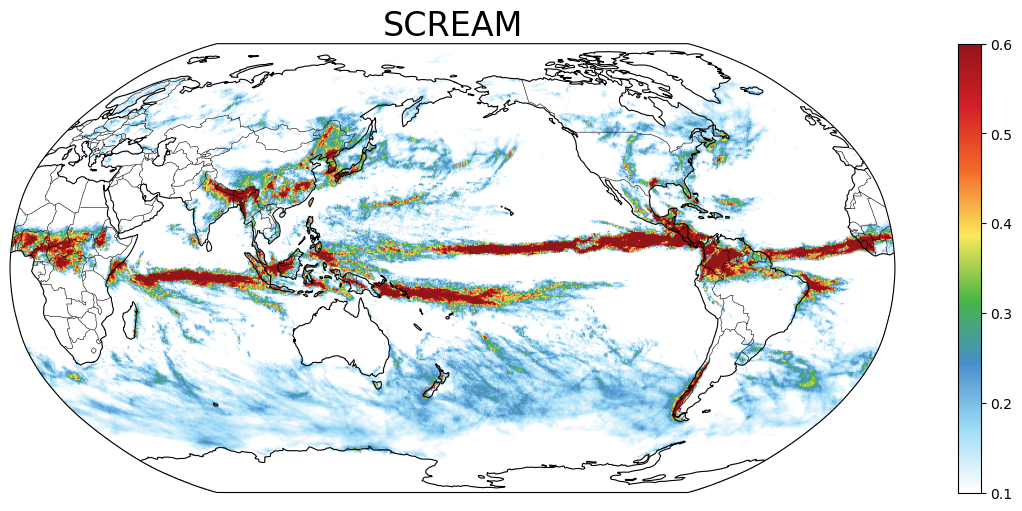

In [55]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cmocean

# Example projection
projection = ccrs.Robinson(central_longitude=180)
fs = 24

# Create figure with 2 subplots
fig, axes = plt.subplots(
    ncols=1,
    figsize=(14, 5),
    subplot_kw={"projection": projection},
    constrained_layout=True
)

# Set same extent for both plots
#extent = [-120, -50, 20, 55]

# First subplot
#axes[0].set_extent(extent, crs=ccrs.PlateCarree())
axes.set_global()
fg = egh.healpix_show(scream_precip_june, ax=axes, cmap=cmp, vmin=.1, vmax=.6)#cmocean.cm.thermal, vmax=0.5)
axes.add_feature(cf.COASTLINE, linewidth=0.8)
axes.add_feature(cf.BORDERS, linewidth=0.4)
axes.set_title("SCREAM", fontsize = fs )
fig.colorbar(fg)
plt.show()

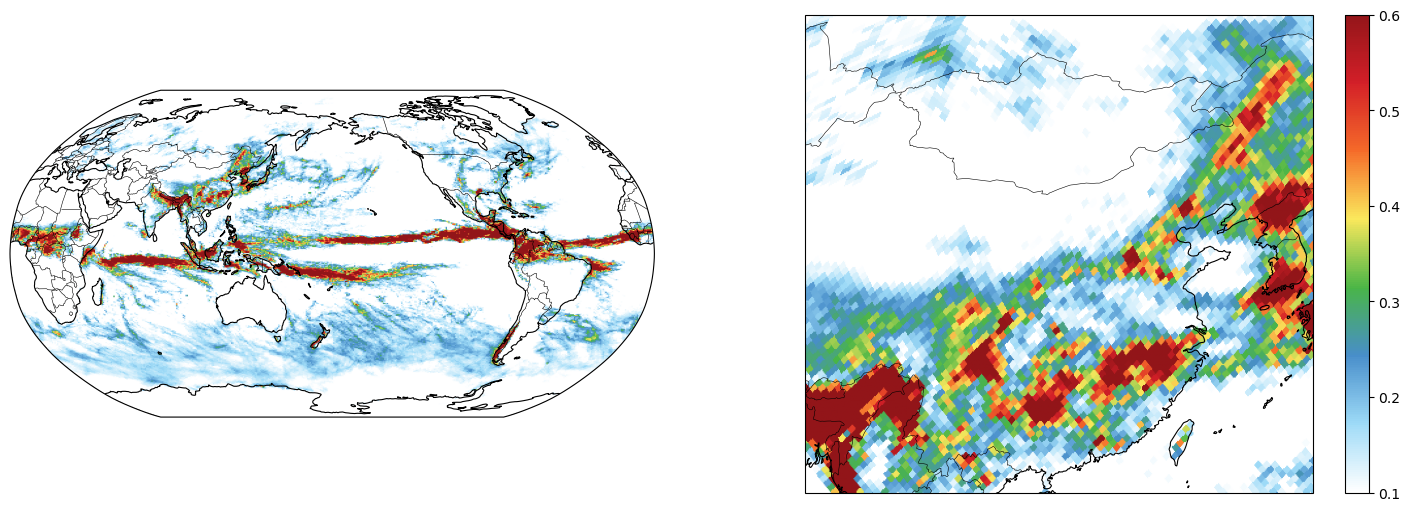

In [57]:
# Create figure with 2 subplots
fig, axes = plt.subplots(
    ncols=2,
    figsize=(14, 5),
    subplot_kw={"projection": projection},
    constrained_layout=True
)

# Set same extent for both plots
extent = [90, 124, 20, 55]

# First subplot
axes[0].set_global()
axes[1].set_extent(extent, crs=ccrs.PlateCarree())
egh.healpix_show(scream_precip_june, ax=axes[0], cmap=cmp, vmin=.1, vmax=.6)
axes[0].add_feature(cf.COASTLINE, linewidth=0.8)
axes[0].add_feature(cf.BORDERS, linewidth=0.4)
#axes[0].set_title("SCREAM", fontsize = fs )
fg = egh.healpix_show(scream_precip_june, ax=axes[1], cmap=cmp, vmin=.1, vmax=.6)#cmocean.cm.thermal, vmax=0.5)
axes[1].add_feature(cf.COASTLINE, linewidth=0.8)
axes[1].add_feature(cf.BORDERS, linewidth=0.4)
fig.colorbar(fg)
plt.show()